# Evaluating DeepLiftSHAP

## Imports and Setup

In [1]:
import os
import platform
from pathlib import Path

# for when on NCC to be able to import local packages
os.chdir(os.path.expanduser("~/l3_project"))
Path.cwd()

PosixPath('/home2/jgcw74/l3_project')

In [2]:
import helpers
import dataset_processing.eurosat

/home2/jgcw74/l3_project/helpers/ml.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
from captum.attr import DeepLiftShap
import shap

import numpy as np
import matplotlib.pyplot as plt
import einops
from tqdm.autonotebook import tqdm

import torch
import torchvision.transforms.v2 as transforms
from safetensors.torch import load_model

In [4]:
print(f'Using PyTorch {torch.__version__} on {platform.system()}')

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'Found {torch.cuda.get_device_name()} to use as a cuda device.')
elif platform.system() == 'Darwin':
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f'Using {device} as torch device.')

if platform.system() != 'Linux':
    torch.set_num_threads(1)  # significantly speeds up data loading processes with less loading overhead
    # see https://discuss.pytorch.org/t/pytorch-v2-high-cpu-consumption/205990 and https://discuss.pytorch.org/t/cpu-usage-far-too-high-and-training-inefficient/57228
    print('Set number of threads to 1 as using a non-Linux machine.')

Using PyTorch 2.5.1 on Linux
Found NVIDIA A100 80GB PCIe MIG 1g.10gb to use as a cuda device.
Using cuda as torch device.


In [5]:
np_rng = np.random.default_rng(42)
_ = torch.manual_seed(42)

# EuroSAT (RGB) Dataset

In [6]:
base_transforms = transforms.Compose([
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=False),  # scaling handles by normalise below
    dataset_processing.core.RSNormaliseTransform(0, 2750),
    # normalise to [0, 1] (based on maximums used in original paper)
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], inplace=True),  # shift to mean 0 and std 1

    # scale as expected by ResNet (see https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet50.html#torchvision.models.ResNet50_Weights)
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    transforms.Resize(224, interpolation=transforms.InterpolationMode.BILINEAR),
])
wrapped_base_transforms = dataset_processing.core.tensor_dict_transform_wrapper(base_transforms)

eurosat_val_ds = dataset_processing.eurosat.get_dataset(
    "val", bands=("B04", "B03", "B02"),  # RGB bands
    transforms=wrapped_base_transforms, download=False
)

print(f"There are {len(eurosat_val_ds)} validation samples.")
print("Image dimensions and label:", eurosat_val_ds[0]["image"].size(), eurosat_val_ds[0]["label"])

There are 5400 validation samples.
Image dimensions and label: torch.Size([3, 224, 224]) tensor(0)


In [7]:
val_dataloader = torch.utils.data.DataLoader(
    eurosat_val_ds, batch_size=32, num_workers=4, shuffle=False, drop_last=False
)
validation_iterator = iter(dataset_processing.core.cycle(val_dataloader))

In [8]:
def show_image(img: torch.Tensor):
    if img.min() < 0:
        img = (img + 1) / 2  # un-normalise
    img = np.transpose(img.cpu(), (1, 2, 0))  # move colour channel to end
    plt.imshow(img)
    plt.axis("off")

## ResNet 50

### Load Model

In [9]:
checkpoints_path = Path.cwd() / 'checkpoints'
assert checkpoints_path.exists()

In [10]:
all_resnet50_saved = list(checkpoints_path.glob('./resnet50/*.st'))
# print(all_resnet50_saved)
latest_resnet50_path = max(all_resnet50_saved, key=os.path.getctime)
latest_resnet50_path

PosixPath('/home2/jgcw74/l3_project/checkpoints/resnet50/FineTunedResNet50_final_ft_weights(0.989).st')

In [11]:
resnet50 = helpers.models.FineTunedResNet50(num_classes=len(eurosat_val_ds.classes)).to(device)

In [12]:
print('Missing/Unexpected keys:', load_model(resnet50, latest_resnet50_path))

Missing/Unexpected keys: (set(), [])


#### Confirm model accuracy

In [13]:
_, acc = helpers.ml.validation_step(
    resnet50, torch.nn.CrossEntropyLoss(), validation_iterator, len(val_dataloader)
)
acc

Validating:   0%|          | 0/169 [00:00<?, ?it/s]

0.9892751479289941

### Run SHAP

In [14]:
deep_shap_explainer = DeepLiftShap(resnet50, multiply_by_inputs=True)  # True for global attribution

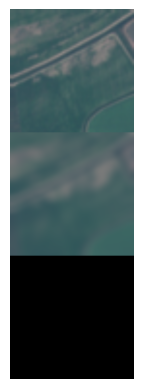

In [15]:
img_to_explain = eurosat_val_ds[1]["image"].to(device)
true_class = eurosat_val_ds[1]["label"]
blurred_img = transforms.functional.gaussian_blur_image(img_to_explain, kernel_size=21, sigma=10)
black_img = torch.zeros_like(img_to_explain) - 1
show_image(torch.column_stack([img_to_explain, blurred_img, black_img]))
# Black background as in https://dl.acm.org/doi/abs/10.1145/3331184.3331312
# Blurred as in https://www.sciencedirect.com/science/article/pii/S0303243421002270

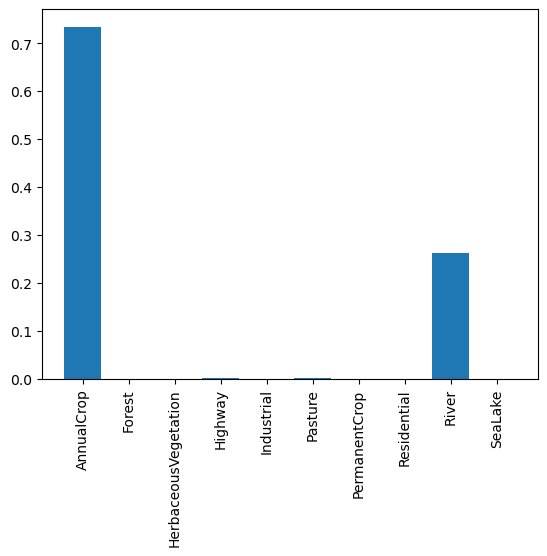

In [16]:
pred = resnet50(img_to_explain.unsqueeze(0))
plt.bar(eurosat_val_ds.classes, torch.nn.functional.softmax(pred, dim=-1).squeeze().cpu().detach().numpy())
_ = plt.xticks(rotation=90)

In [17]:
blurred_background_imgs = transforms.functional.gaussian_blur_image(
    torch.stack([eurosat_val_ds[i]["image"] for i in np_rng.integers(0, len(eurosat_val_ds), 100)]),
    kernel_size=15, sigma=10
).to(device)

In [40]:
shap_vals = torch.zeros(0).to(device)
for i in tqdm(range(len(eurosat_val_ds.classes))):
    shap_values_for_ith_label = deep_shap_explainer.attribute(
        img_to_explain.unsqueeze(0), blurred_img.unsqueeze(0).repeat_interleave(2, dim=0),
        # blurred_background_imgs[:10],
        target=torch.tensor(i).to(device)
    ).detach()
    shap_vals = torch.cat(
        (shap_vals, shap_values_for_ith_label),
        dim=0
    ) if shap_vals.size else shap_values_for_ith_label

  0%|          | 0/10 [00:00<?, ?it/s]

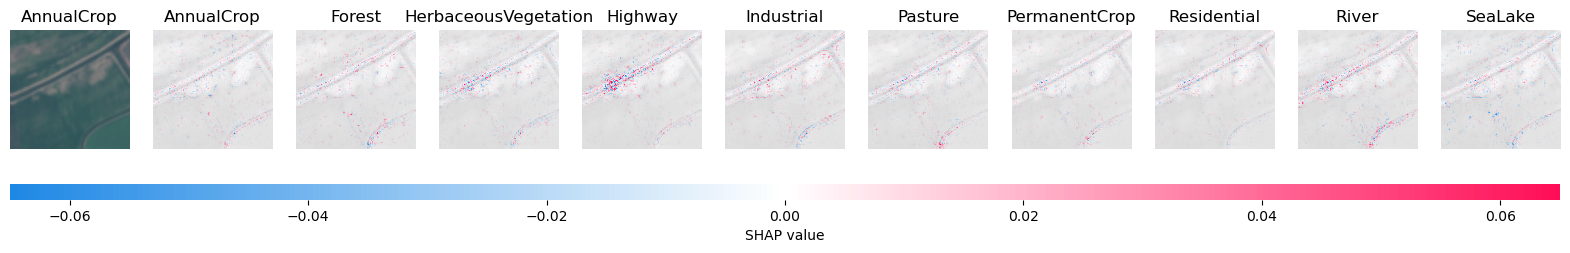

In [41]:
shap.image_plot(
    list(einops.rearrange(shap_vals.unsqueeze(0), "b t c h w -> t b h w c").cpu().numpy()),
    einops.rearrange((img_to_explain.unsqueeze(0) + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (img_to_explain.shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in [true_class]]
)

#### Pooled SHAP

In [42]:
pool_size = 8
pooled_shap_vals = (pool_size ** 2) * torch.nn.AvgPool2d(kernel_size=pool_size, stride=pool_size)(
    shap_vals).repeat_interleave(pool_size, dim=-2).repeat_interleave(pool_size, dim=-1)

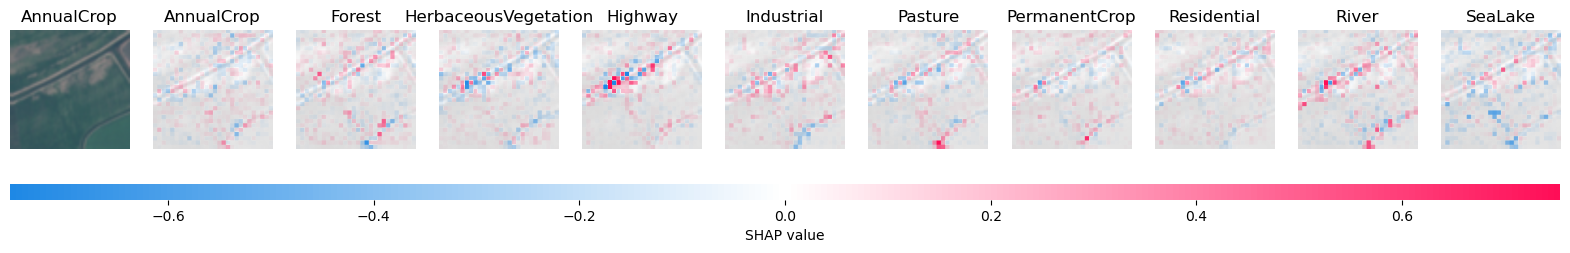

In [43]:
shap.image_plot(
    list(einops.rearrange(pooled_shap_vals.unsqueeze(0), "b t c h w -> t b h w c").cpu().numpy()),
    einops.rearrange((img_to_explain.unsqueeze(0) + 1) / 2, "b c h w -> b h w c").cpu().numpy(),
    labels=np.tile(eurosat_val_ds.classes, (img_to_explain.shape[0], 1)),
    true_labels=[eurosat_val_ds.classes[int(i)] for i in [true_class]]
)

#### Original SHAP library

In [67]:
def predict_fn(input_np_img):
    permuted_img = einops.rearrange(torch.Tensor(input_np_img), "b h w c -> b c h w").to(device)
    return resnet50(permuted_img).cpu().detach().numpy()

In [68]:
np_imgs_to_explain = einops.rearrange((img_to_explain.unsqueeze(0) + 1) / 2, "b c h w -> b h w c").cpu().numpy()

In [69]:
masker_blur = shap.maskers.Image("blur(64,64)", np_imgs_to_explain[0].shape)
explainer = shap.Explainer(predict_fn, masker_blur, output_names=eurosat_val_ds.classes)

In [70]:
shap_values = explainer(
    np_imgs_to_explain,
    max_evals=10000,
    batch_size=32,
    outputs=shap.Explanation.argsort.flip[:4],
)

  0%|          | 0/9998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:40, 40.99s/it]               


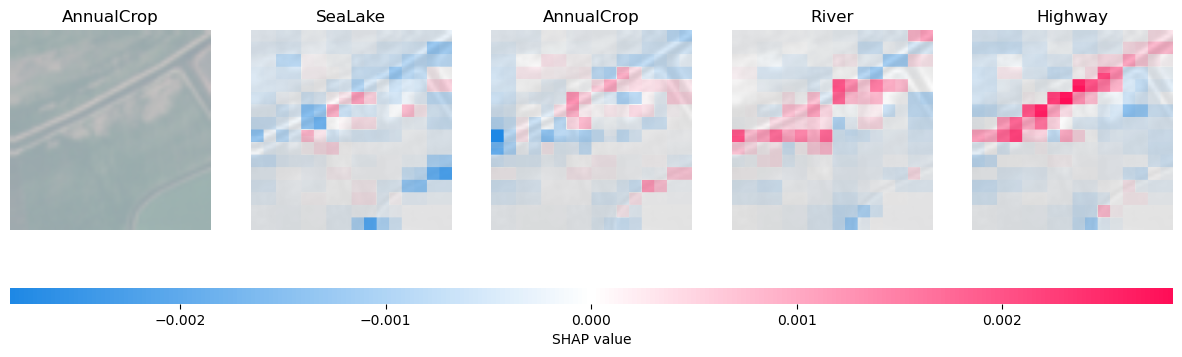

In [71]:
shap.image_plot(
    shap_values=[val for val in np.moveaxis(shap_values.values[0], -1, 0)],
    pixel_values=((shap_values.data + 1) / 2)[0],
    labels=shap_values.output_names,
    true_labels=[eurosat_val_ds.classes[int(i)] for i in [true_class]],
)

In [74]:
resnet50(img_to_explain.unsqueeze(0)).cpu().detach().numpy()

array([[ 9.504877  , -7.7397275 , -0.879064  ,  2.8542154 , -6.3789983 ,
         3.66639   , -2.915345  , -8.032182  ,  8.476496  ,  0.44281298]],
      dtype=float32)